# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import packages

# data extraction
from sqlalchemy import create_engine

# standard data processing
import pandas as pd
import numpy as np
import sys

# tokenization
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [8]:
def load_data():
    # load data from database
    engine = create_engine('sqlite:///TweetsDatabase.db')
    df = pd.read_sql_table('TweetsDatabase', engine)
    
    # defining features - X and labels y
    X = df['message']
    y = df.drop(['id','original','message','genre'], axis = 1)
    
    # Replacing rougue 2 values
    y.related.replace('2','1',inplace=True)
    y = y.astype(int)
    return X,y

In [ ]:
X,y = load_data()

In [12]:
print(np.unique(y))

[0 1]


### 2. Write a tokenization function to process your text data

In [121]:
def tokenize(text):
    # text cleaning
    text = text.lower() # Convert to lowercase
    text = re.sub('[^A-Za-z0-9]+',' ', text) # removing punctuation
    words = nltk.word_tokenize(text) # tokenizing words
    stop_words = set(stopwords.words('english')) # adding set of stopwords
    filtered_words = [w for w in words if not w.lower() in stop_words] # filtering words
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token
    clean_tokens = []
    for tok in filtered_words:
        # lemmatization
        clean_tok = lemmatizer.lemmatize(tok)
        clean_tokens.append(clean_tok)
    return clean_tokens

### My experimenting with pipelines

In [122]:
def display_results(y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

In [127]:
# Extracting sklearn liabraries

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=56)
print(np.unique(y_train))

# https://github.com/ageron/handson-ml/issues/360 - look here

['0' '1' '2']


In [129]:
# trying to convert predictions to single - digits

In [131]:
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

vect = CountVectorizer(tokenizer=tokenize)
tfidf = TfidfTransformer()
clf = RandomForestClassifier(n_estimators = 100) # random forest consumes too much memory
#clf = MultiOutputClassifier(SGDClassifier(random_state=42), n_jobs=1)

# train classifier
X_train_counts = vect.fit_transform(X_train) # tokenizing train features
X_train_tfidf = tfidf.fit_transform(X_train_counts)
clf.fit(X_train_tfidf, y_train)

# predict on test data
X_test_counts = vect.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)
y_pred = clf.predict(X_test_tfidf)


### Previewing results

In [132]:
y_test.shape

(5206, 36)

In [133]:
y_pred.shape

(5206, 36)

In [134]:
y.related.unique()

array([1, 0])

In [135]:
y_pred

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [136]:
y_test

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
22652,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23202,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11998,1,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
8262,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19407,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14882,1,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5814,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [137]:
labels = np.unique(y_pred)
print(labels)

[0 1]


In [138]:
confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1), labels = labels)

array([[5206,    0],
       [   0,    0]])

In [139]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[ 604,  654],
        [ 265, 3683]],

       [[4203,   82],
        [ 468,  453]],

       [[5185,    0],
        [  21,    0]],

       [[2757,  301],
        [ 924, 1224]],

       [[4797,    6],
        [ 395,    8]],

       [[4943,   10],
        [ 241,   12]],

       [[5062,    7],
        [ 131,    6]],

       [[5097,    0],
        [ 109,    0]],

       [[5037,    2],
        [ 162,    5]],

       [[5206,    0],
        [   0,    0]],

       [[4887,   13],
        [ 205,  101]],

       [[4578,   51],
        [ 316,  261]],

       [[4702,   20],
        [ 362,  122]],

       [[5120,    5],
        [  73,    8]],

       [[5083,    1],
        [ 117,    5]],

       [[5141,    0],
        [  65,    0]],

       [[5021,    7],
        [ 173,    5]],

       [[4975,    2],
        [ 214,   15]],

       [[4521,   24],
        [ 627,   34]],

       [[4868,    2],
        [ 335,    1]],

       [[4984,    0],
        [ 219,    3]],

       [[4953,    5],
        [ 23

In [140]:
#confusion_matrix(np.asarray(y_test, np.asarray(y_pred).argmax(axis=1)))

In [141]:
from sklearn.metrics import f1_score

In [142]:
f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.5330398196300957

In [143]:
from sklearn.metrics import precision_score, recall_score

In [144]:
precision_score(y_true=y_test, y_pred=y_pred, average='weighted')

/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7524504342398644

In [145]:
recall_score(y_true=y_test, y_pred=y_pred, average='weighted')

/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4767342452369321

### Confusion matrix visualization

In [146]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [147]:
# defining labels 
labels = list(y_test.columns.values)
print(labels)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [148]:
len(labels)

36

In [149]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred)

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

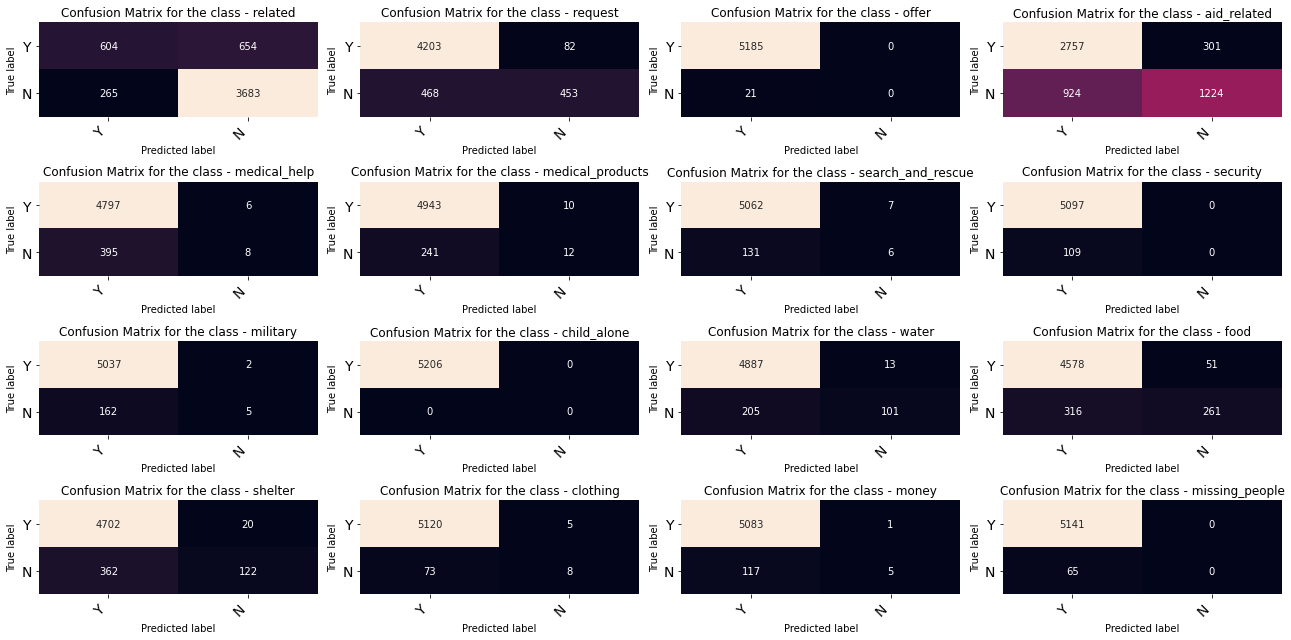

In [151]:
fig, ax = plt.subplots(4, 4, figsize=(18, 9))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"]) # WARNING: verify that this is the right place for TP/TN

fig.tight_layout()
plt.show()

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [ ]:
pipeline = 

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.